In [1]:
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings('ignore')
df = pd.read_csv('concat_data.csv', index_col=0)
df = df[df['Totaltweets'] > 7]
df

,BTCtweets,Totaltweets,btc_neg_avg,btc_pos_avg,btc_neu_avg,btc_com_avg,neg_avg,pos_avg,neu_avg,com_avg,...,low,open,volume,close,MOM_10,SMA_5,SMA_10,RSI_14,MFI_14,nxt_day_return
2021-12-27,3,28,0.000000,0.000000,1.000000,0.000000,0.035000,0.110107,0.854893,0.160389,...,50481.26,50790.88,21873.37,50714.73,4550.59,50721.560,49161.254,50.184461,67.266131,0
2022-01-02,3,21,0.000000,0.173333,0.826667,0.360833,0.037714,0.100143,0.862190,0.149724,...,46666.18,47737.35,13025.66,47306.41,-3523.79,46968.486,48515.642,42.748259,54.404861,0
2022-01-03,32,192,0.074000,0.078000,0.847938,0.018784,0.031240,0.113922,0.854833,0.167254,...,45707.55,47306.41,21681.38,46450.79,-4389.57,46964.304,48076.685,40.331117,56.043310,0
2022-01-04,21,170,0.060048,0.065190,0.874762,-0.024548,0.045288,0.097582,0.857118,0.109683,...,45587.91,46450.79,29035.93,45824.54,-4607.09,46703.280,47615.976,38.610286,47.576684,0
2022-01-05,55,159,0.049582,0.089236,0.861182,0.068989,0.044516,0.115711,0.839780,0.126904,...,42510.86,45824.54,47769.20,43432.51,-7358.37,46150.320,46880.139,32.845565,38.988227,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-11,19,95,0.043526,0.141211,0.815263,0.253489,0.029400,0.111147,0.859453,0.171907,...,36701.83,37321.51,14920.50,37142.22,1702.46,36445.610,35708.763,81.878959,82.475460,0
2023-11-12,13,78,0.034769,0.135846,0.829385,0.318123,0.015897,0.125385,0.858718,0.294297,...,36747.05,37142.22,9320.87,37079.76,2132.61,36777.192,35922.024,80.940404,79.593163,0
2023-11-13,18,56,0.032722,0.110944,0.856333,0.291211,0.043268,0.109250,0.847482,0.264696,...,36358.00,37079.76,24368.53,36482.51,1750.23,36946.028,36097.047,72.394964,72.705580,0
2023-11-14,39,104,0.056564,0.089333,0.854077,0.164946,0.051760,0.118000,0.830192,0.193777,...,34788.17,36482.51,33896.65,35551.21,465.12,36715.442,36143.559,61.492826,70.225090,1


In [2]:
# Choose predictors and y
predictors_name = ['BTCtweets', 'Totaltweets', 'btc_pos_avg', 'btc_neg_avg', 'pos_avg', 'neg_avg', 
                   'volume', 'MOM_10', 'SMA_5', 'SMA_10', 'RSI_14', 'MFI_14']
y_name = ['nxt_day_return']
df_X = df[predictors_name]
df_y = df[y_name]

# Split train and test set
from sklearn.model_selection import train_test_split
# As the data is time series, do not shuffle the data
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3, shuffle=False)
print('Train dataset: The proportion of positive return on the next day (y=1) is %.3f' % (float(y_train.mean())))
print('Test  dataset: The proportion of positive return on the next day (y=1) is %.3f' % (float(y_test.mean())))

Train dataset: The proportion of positive return on the next day (y=1) is 0.438
Test  dataset: The proportion of positive return on the next day (y=1) is 0.438


**As the distribution of different values of y is nearly equal in the train and test set, I do not shuffle the data to keep the time order of the data**

In [3]:
from sklearn.preprocessing import StandardScaler

# Standardized data
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [4]:
from sklearn.metrics import (confusion_matrix, roc_curve, auc, f1_score,
                            ConfusionMatrixDisplay, RocCurveDisplay, accuracy_score)
import matplotlib.pyplot as plt
# A function return all scores and graph I need to evaluate the model
def evaluation(estimator, X_test, y_test):
    y_pred = estimator.predict(X_test)
    
    RocCurveDisplay.from_estimator(estimator, X_test, y_test, plot_chance_level=True)
    plt.title('Receiver Operating Characteristic (ROC) Curve')

    ConfusionMatrixDisplay.from_estimator(estimator, X_test, y_test, cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')

    plt.tight_layout()
    plt.show()
    print('The f1_score is %.3f' % f1_score(y_test, y_pred))
    print('The acc is %.3f' % accuracy_score(y_test, y_pred))
    return 

**First, without feature engineering**

**Logistic Regression**

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import KernelPCA


lr = LogisticRegression(solver='liblinear')
c_range = [10. ** c for c in range(-4, 5)]
param_grid = [{'C': c_range, 
              'penalty': ['l1', 'l2']}]
gs_lr = GridSearchCV(estimator=lr,
                    param_grid=param_grid,
                    scoring='accuracy',
                    cv=10,
                    refit=True)

Train without tweets data

{'C': 0.0001, 'penalty': 'l1'}
Training acc is 0.562


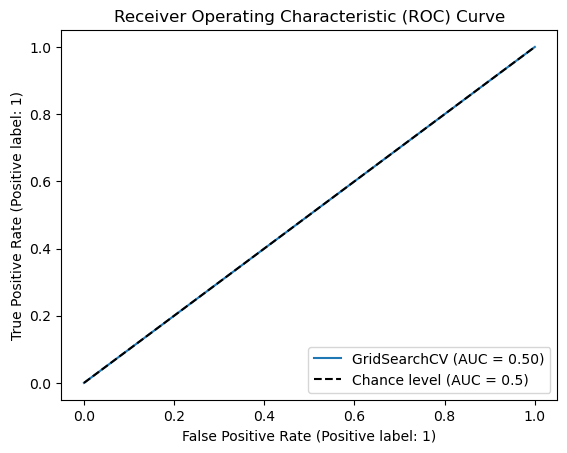

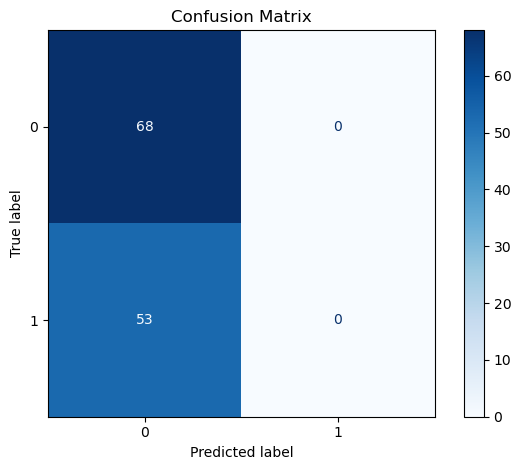

The f1_score is 0.000
The acc is 0.562


In [6]:
# Train without tweets data
gs_lr.fit(X_train_std[:, -6:], y_train)
print(gs_lr.best_params_)
print('Training acc is %.3f' % accuracy_score(y_test, gs_lr.predict(X_test_std[:, -6:])))
# Plot confusion matrix and ROC
evaluation(gs_lr, X_test_std[:, -6:], y_test)

Train with tweets data

{'C': 0.0001, 'penalty': 'l1'}
Training acc is 0.562


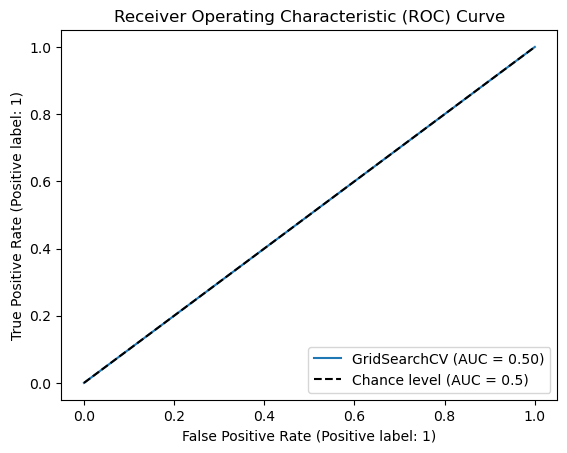

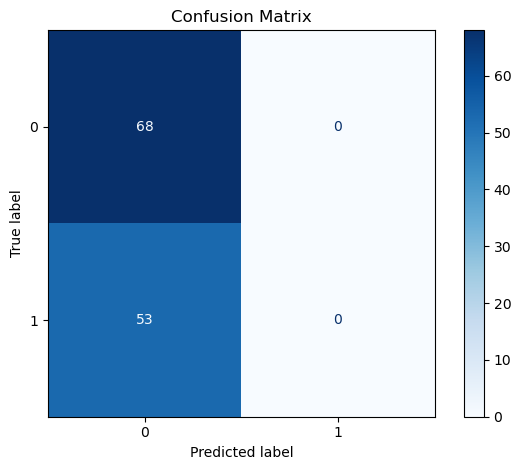

The f1_score is 0.000
The acc is 0.562


In [7]:
# Train with tweets data
gs_lr.fit(X_train_std, y_train)
print(gs_lr.best_params_)
print('Training acc is %.3f' % accuracy_score(y_test, gs_lr.predict(X_test_std)))
# Plot confusion matrix and ROC
evaluation(gs_lr, X_test_std, y_test)

**SVM(Kernel)**

In [8]:
from sklearn.svm import SVC

svc = SVC()
param_grid = [{'C': c_range,
              'kernel': ['linear']},
             {'C': c_range,
              'kernel': ['rbf'],
             'gamma': ['scale', 'auto']},
             {'C': c_range,
              'kernel': ['rbf'],
             'gamma': ['scale', 'auto'],
             'degree': list(range(2, 6))}]
gs_svc = GridSearchCV(estimator=svc,
                    param_grid=param_grid,
                    scoring='accuracy',
                    cv=10,
                    refit=True)

Train without tweets data

{'C': 0.0001, 'kernel': 'linear'}
Training acc is 0.562


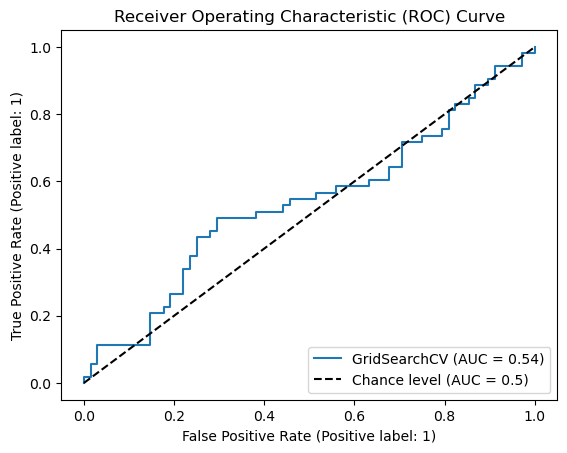

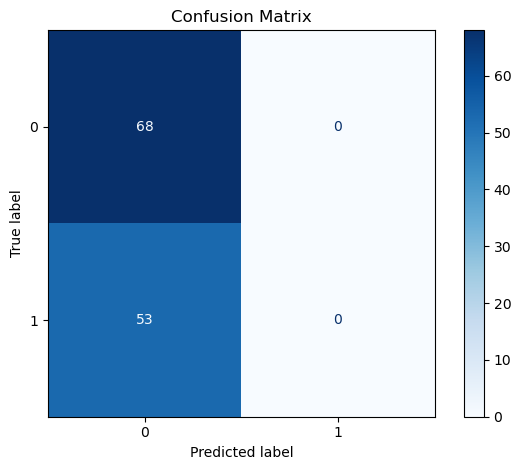

The f1_score is 0.000
The acc is 0.562


In [9]:
# Train without tweets data
gs_svc.fit(X_train_std[:, -6:], y_train)
print(gs_svc.best_params_)
print('Training acc is %.3f' % accuracy_score(y_test, gs_svc.predict(X_test_std[:, -6:])))
# Plot confusion matrix and ROC
evaluation(gs_svc, X_test_std[:, -6:], y_test)

Train with tweets data

{'C': 0.0001, 'kernel': 'linear'}
Training acc is 0.562


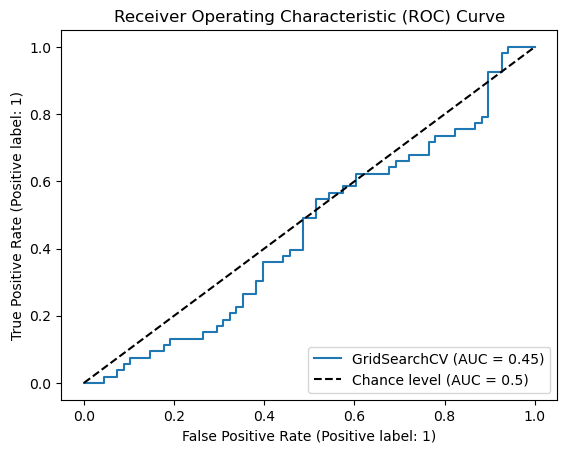

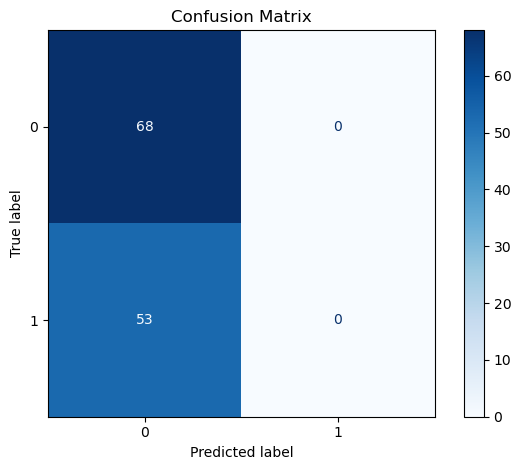

The f1_score is 0.000
The acc is 0.562


In [10]:
# Train with tweets data
gs_svc.fit(X_train_std, y_train)
print(gs_svc.best_params_)
print('Training acc is %.3f' % accuracy_score(y_test, gs_svc.predict(X_test_std)))
# Plot confusion matrix and ROC
evaluation(gs_svc, X_test_std, y_test)

**Random Forest**

In [11]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
param_grid = [{'n_estimators': list(np.arange(10, 210, 10)), 
              'max_depth': [None, 1, 2, 3],
             'max_features': ['sqrt', 'log2', None]}]

gs_rf = GridSearchCV(estimator=rf,
                    param_grid=param_grid,
                    scoring='accuracy',
                    cv=10,
                    refit=True)

Train without tweets data

{'max_depth': 1, 'max_features': 'log2', 'n_estimators': 30}
Training acc is 0.562


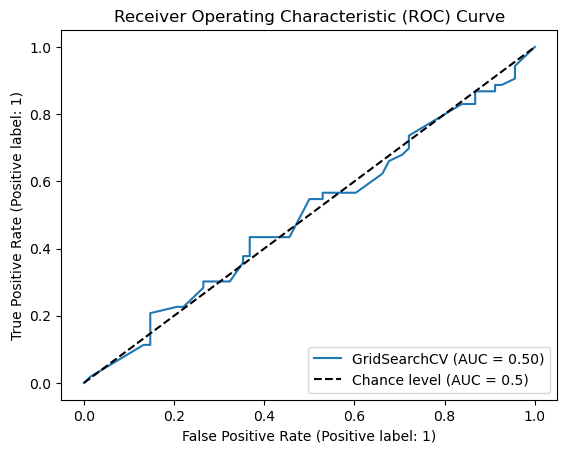

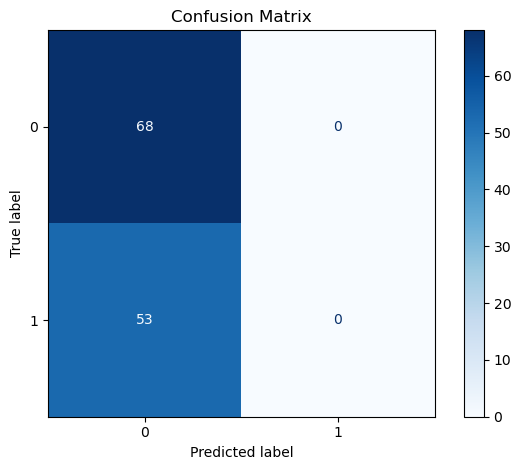

The f1_score is 0.000
The acc is 0.562


In [12]:
# Train without tweets data
gs_rf.fit(X_train_std[:, -6:], y_train)
print(gs_rf.best_params_)
print('Training acc is %.3f' % accuracy_score(y_test, gs_rf.predict(X_test_std[:, -6:])))
# Plot confusion matrix and ROC
evaluation(gs_rf, X_test_std[:, -6:], y_test)

Train with tweets data

{'max_depth': 1, 'max_features': 'sqrt', 'n_estimators': 170}
Training acc is 0.562


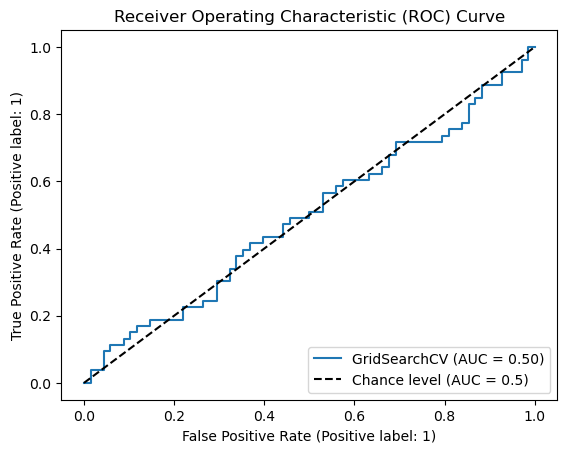

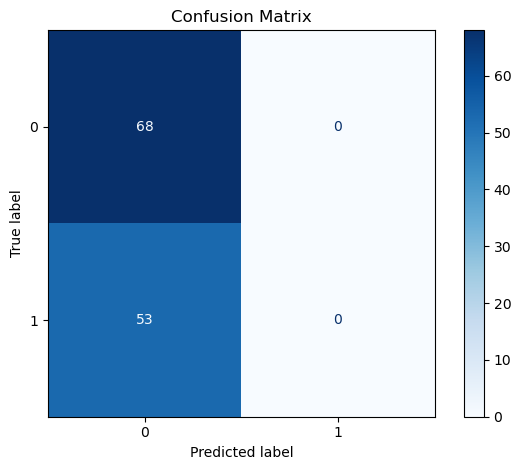

The f1_score is 0.000
The acc is 0.562


In [13]:
# Train with tweets data
gs_rf.fit(X_train_std, y_train)
print(gs_rf.best_params_)
print('Training acc is %.3f' % accuracy_score(y_test, gs_rf.predict(X_test_std)))
# Plot confusion matrix and ROC
evaluation(gs_rf, X_test_std, y_test)

**Adaboosting**

In [14]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier()
ada = AdaBoostClassifier(estimator=tree)
param_grid = [{'n_estimators': list(np.arange(10, 210, 10)), 
              'learning_rate': list(np.arange(0.1, 1.1, 0.1)),
             }]

gs_ada = GridSearchCV(estimator=ada,
                    param_grid=param_grid,
                    scoring='accuracy',
                    cv=10,
                    refit=True)

Train without tweets data

{'learning_rate': 0.1, 'n_estimators': 60}
Training acc is 0.529


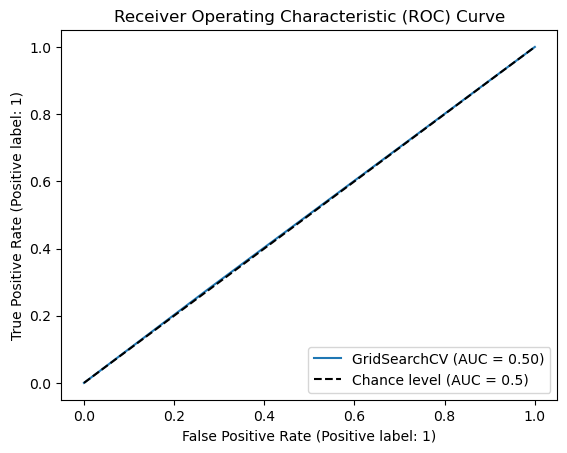

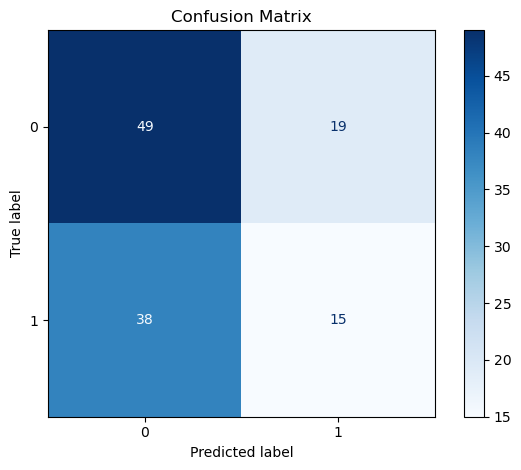

The f1_score is 0.345
The acc is 0.529


In [15]:
# Train without tweets data
gs_ada.fit(X_train_std[:, -6:], y_train)
print(gs_ada.best_params_)
print('Training acc is %.3f' % accuracy_score(y_test, gs_ada.predict(X_test_std[:, -6:])))
# Plot confusion matrix and ROC
evaluation(gs_ada, X_test_std[:, -6:], y_test)

Train with tweets data

{'learning_rate': 0.6, 'n_estimators': 60}
Training acc is 0.471


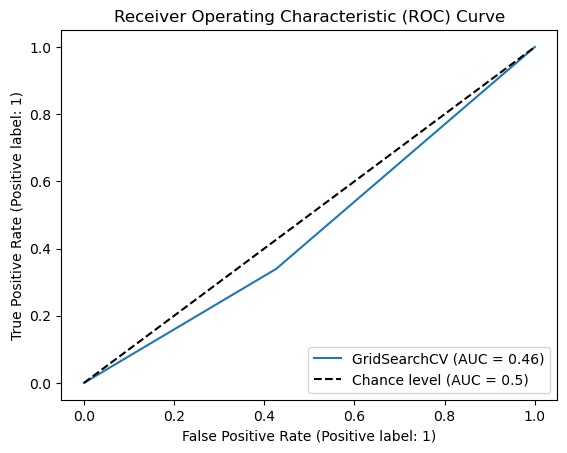

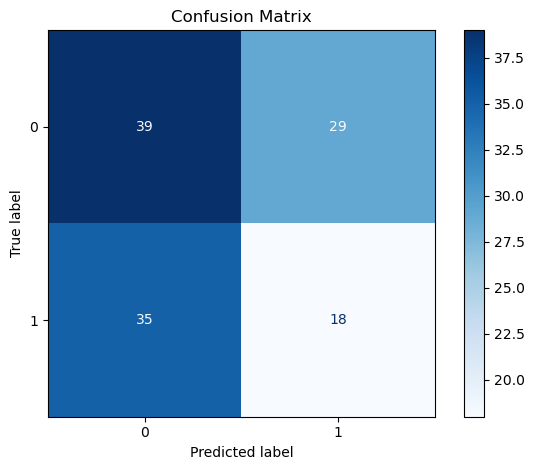

The f1_score is 0.360
The acc is 0.471


In [16]:
# Train with tweets data
gs_ada.fit(X_train_std, y_train)
print(gs_ada.best_params_)
print('Training acc is %.3f' % accuracy_score(y_test, gs_ada.predict(X_test_std)))
# Plot confusion matrix and ROC
evaluation(gs_ada, X_test_std, y_test)

**Second, with feature engineering (PCA)** \
***1)Test whether feature engineering can improve the prediction*** \
***2)As only ensemble learning show meaningful result, I only use RF and Adaboost***

1) PCA

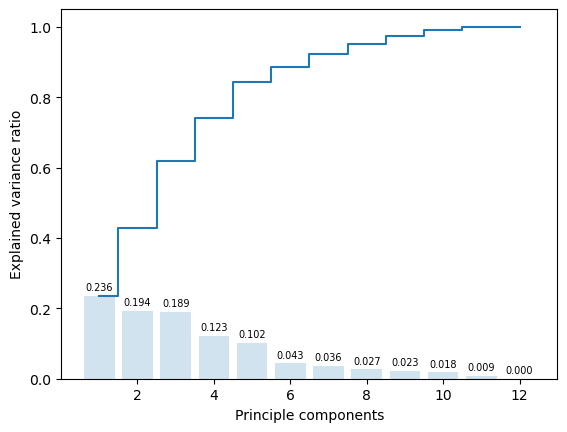

In [17]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_train_std)
plt.bar(range(1, X_train.shape[1]+1), pca.explained_variance_ratio_, alpha=0.2, align='center')
plt.step(range(1, X_train.shape[1]+1), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.xlabel('Principle components')
plt.ylabel('Explained variance ratio')
for idx, lab in zip(range(1, X_train.shape[1]+1), pca.explained_variance_ratio_):
    plt.text(idx, lab+0.01, '%.3f'% lab, ha='center', va='bottom', fontsize=7)

plt.show()

Training acc is 0.562


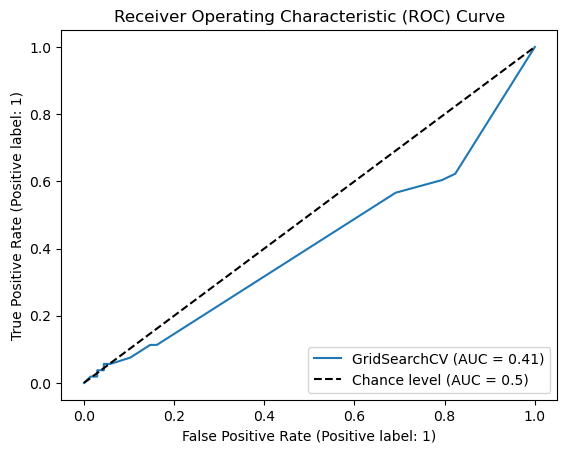

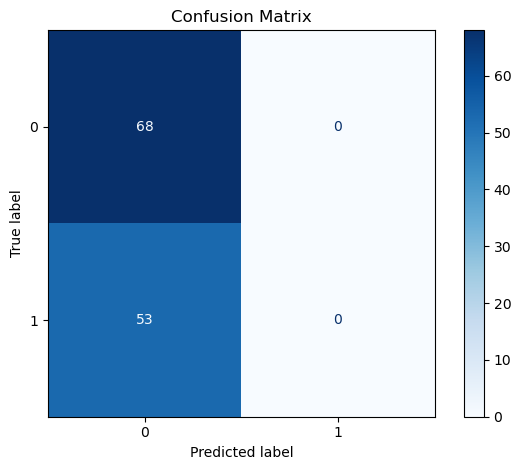

The f1_score is 0.000
The acc is 0.562


In [18]:
# Extract 5 factors
pca = PCA(n_components=5)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

# Test RF model
gs_rf.fit(X_train_pca, y_train)
print('Training acc is %.3f' % accuracy_score(y_test, gs_rf.predict(X_test_pca)))
# Plot confusion matrix and ROC
evaluation(gs_rf, X_test_pca, y_test)

{'learning_rate': 0.7000000000000001, 'n_estimators': 200}
Training acc is 0.479


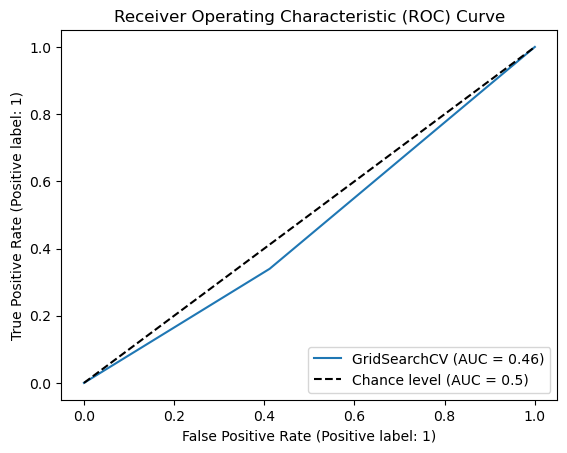

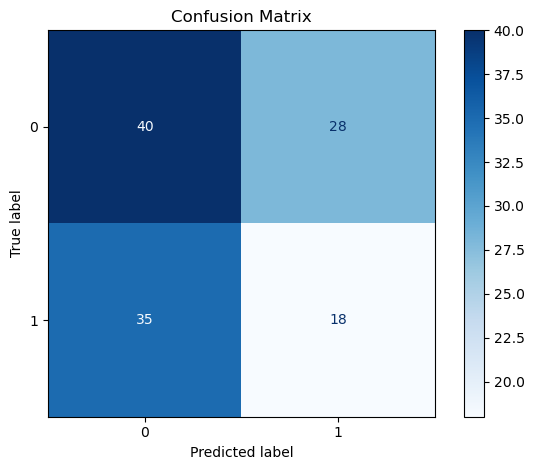

The f1_score is 0.364
The acc is 0.479


In [19]:
# Test Adaboost model
gs_ada.fit(X_train_pca, y_train)
print(gs_ada.best_params_)
print('Training acc is %.3f' % accuracy_score(y_test, gs_ada.predict(X_test_pca)))
# Plot confusion matrix and ROC
evaluation(gs_ada, X_test_pca, y_test)

2) Kernel PCA

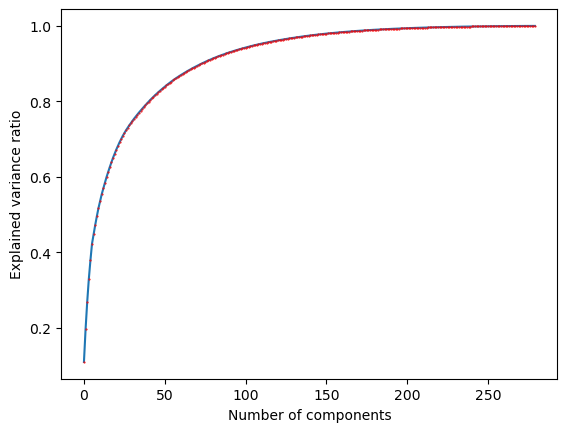

In [20]:
from sklearn.decomposition import KernelPCA

# Find a proper number of components
pca = KernelPCA(kernel='rbf')
pca.fit(X_train_std)
plt.plot(np.cumsum(pca.eigenvalues_)/np.sum(pca.eigenvalues_), marker='o', ms=0.5, mec='r')
plt.xlabel('Number of components')
plt.ylabel('Explained variance ratio')
plt.show()

Base on the graph, I choose n_components=50

{'max_depth': 1, 'max_features': 'sqrt', 'n_estimators': 80}
Training acc is 0.562


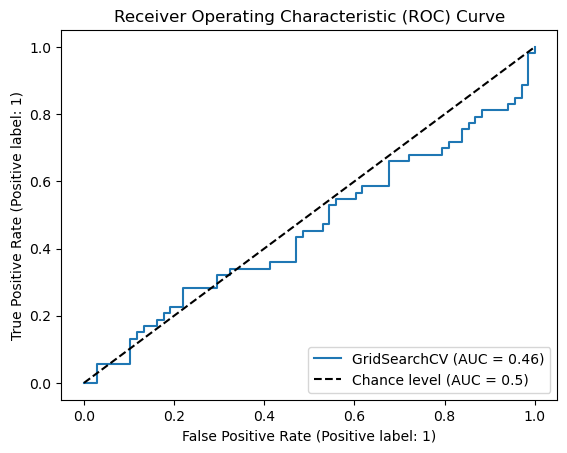

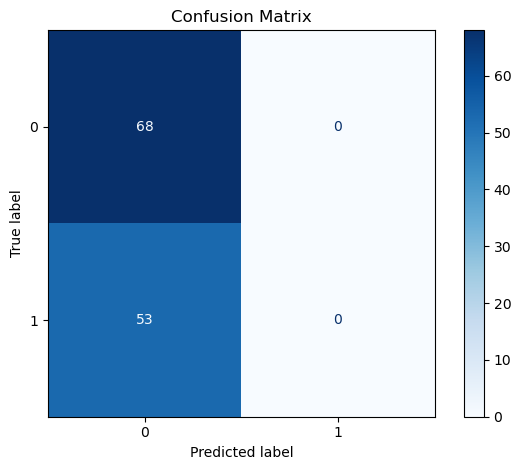

The f1_score is 0.000
The acc is 0.562


In [21]:
pca = KernelPCA(kernel='rbf', n_components=50)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

# Test RF model
gs_rf.fit(X_train_pca, y_train)
print(gs_rf.best_params_)
print('Training acc is %.3f' % accuracy_score(y_test, gs_rf.predict(X_test_pca)))
# Plot confusion matrix and ROC
evaluation(gs_rf, X_test_pca, y_test)

{'learning_rate': 0.8, 'n_estimators': 90}
Training acc is 0.537


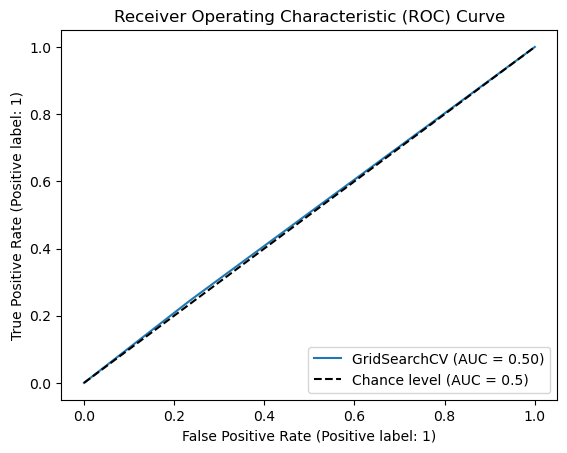

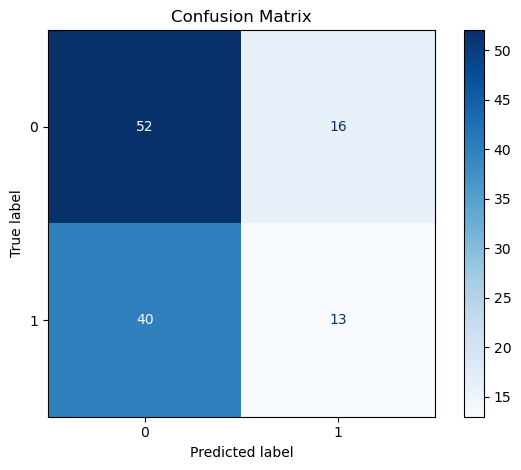

The f1_score is 0.317
The acc is 0.537


In [22]:
# Test Adaboost model
gs_ada.fit(X_train_pca, y_train)
print(gs_ada.best_params_)
print('Training acc is %.3f' % accuracy_score(y_test, gs_ada.predict(X_test_pca)))
# Plot confusion matrix and ROC
evaluation(gs_ada, X_test_pca, y_test)